# Exploratory Data Analysis (EDA)

*Notebook 01_EDA*

## 1. 导入库

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 可选：%matplotlib inline
sns.set(style="whitegrid")

## 2. 加载数据

In [28]:
df = pd.read_csv('../data/custom_covid19.csv')
print("Data snapshot:")
display(df.head())

Data snapshot:


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,TEST_RESULT,ICU
0,2,12,1,1,9999-99-99,97,2,41,2,2,...,2,2,2,2,2,2,2,2,7,97
1,2,12,2,1,9999-99-99,97,2,57,2,1,...,2,2,2,2,2,1,2,1,5,97
2,2,4,2,1,9999-99-99,97,2,38,2,2,...,2,2,2,2,2,1,2,1,3,97
3,2,9,1,1,9999-99-99,97,2,68,2,2,...,2,2,2,2,1,2,2,2,7,97
4,1,12,2,1,9999-99-99,97,2,63,2,2,...,2,2,1,2,2,2,2,2,7,97


## 3. 数据概览

In [29]:
print("Shape:", df.shape)

# 将特殊值 97,98,99 视为缺失
missing_vals = [97, 98, 99]
df.replace(missing_vals, np.nan, inplace=True)

print("Missing counts per column:")
display(df.isnull().sum())

Shape: (100000, 21)
Missing counts per column:


USMER                 0
MEDICAL_UNIT          0
SEX                   0
PATIENT_TYPE          0
DATE_DIED             0
INTUBED           81491
PNEUMONIA          1577
AGE                  31
PREGNANT            352
DIABETES            343
COPD                295
ASTHMA              287
INMSUPR             331
HYPERTENSION        301
OTHER_DISEASE       456
CARDIOVASCULAR      294
OBESITY             276
RENAL_CHRONIC       295
TOBACCO             326
TEST_RESULT           0
ICU               81502
dtype: int64

## 4. 异常值检测（AGE）

使用 IQR 方法检测年龄离群值

In [30]:
def detect_outliers(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)
    return series[mask]

outliers_age = detect_outliers(df['AGE'].dropna())
print(f"AGE outliers: {len(outliers_age)} records")
display(outliers_age.describe())

AGE outliers: 811 records


count    811.000000
mean      89.351418
std        3.724932
min       86.000000
25%       87.000000
50%       88.000000
75%       91.000000
max      121.000000
Name: AGE, dtype: float64

## 5. 年龄分布

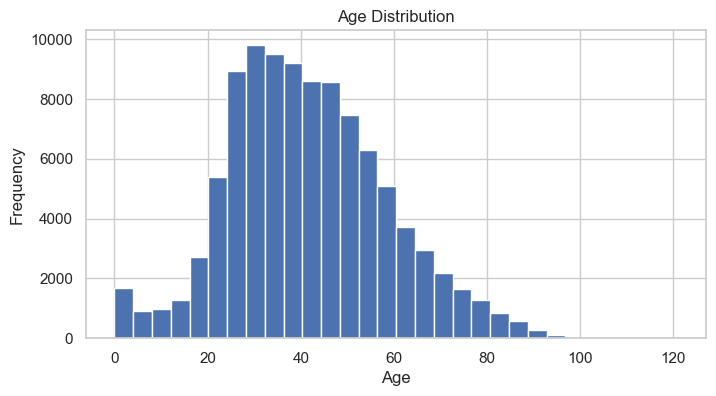

In [31]:
plt.figure(figsize=(8,4))
plt.hist(df['AGE'].dropna(), bins=30)
plt.title('Age Distribution')
plt.xlabel('Age'); plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 6. 目标变量（死亡）分布

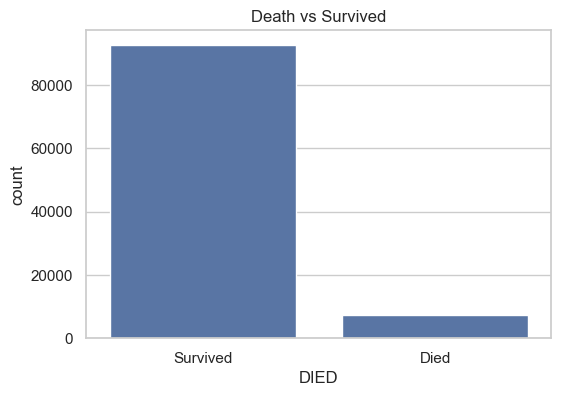

In [32]:
df['DIED'] = (df['DATE_DIED'] != '9999-99-99').astype(int)
plt.figure(figsize=(6,4))
sns.countplot(x='DIED', data=df)
plt.xticks([0,1], ['Survived','Died'])
plt.title('Death vs Survived')
plt.show()

## 7. 分类变量与死亡率联合分析



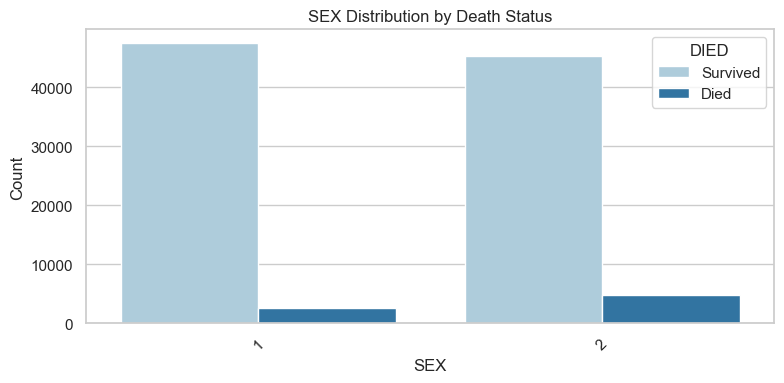

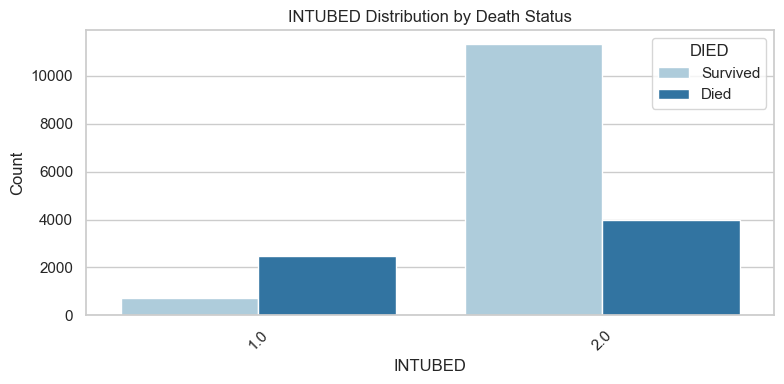

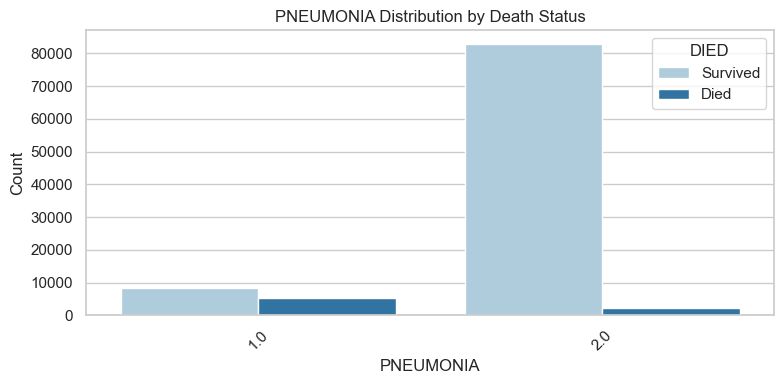

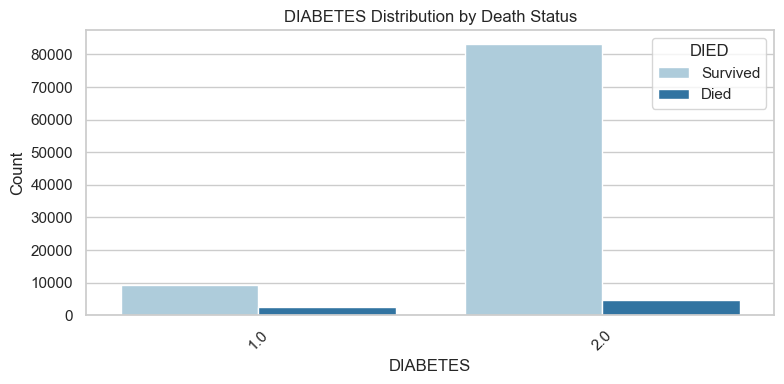

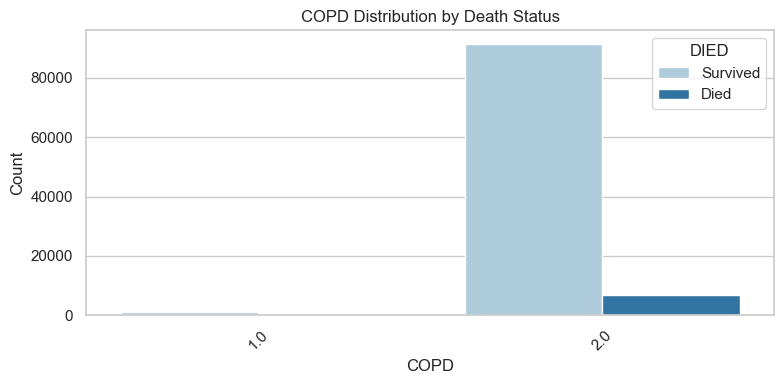

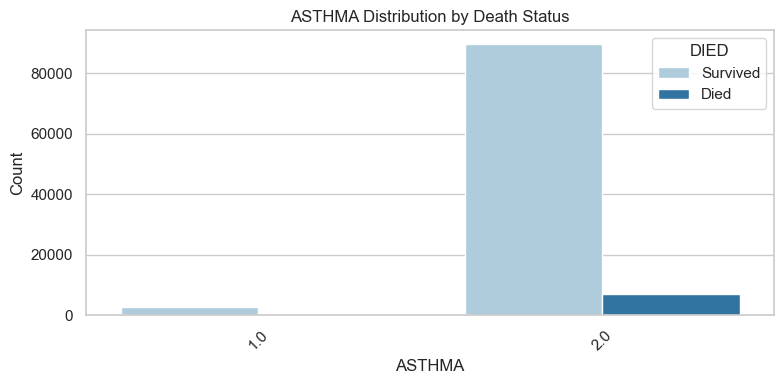

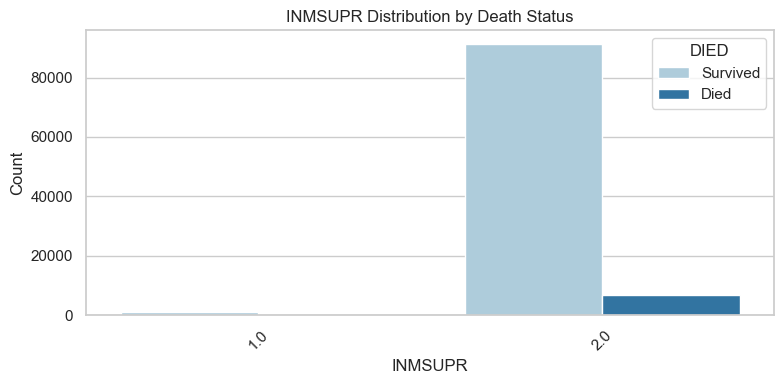

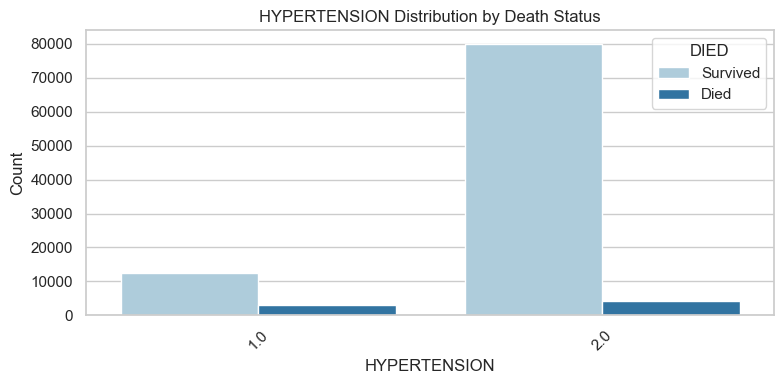

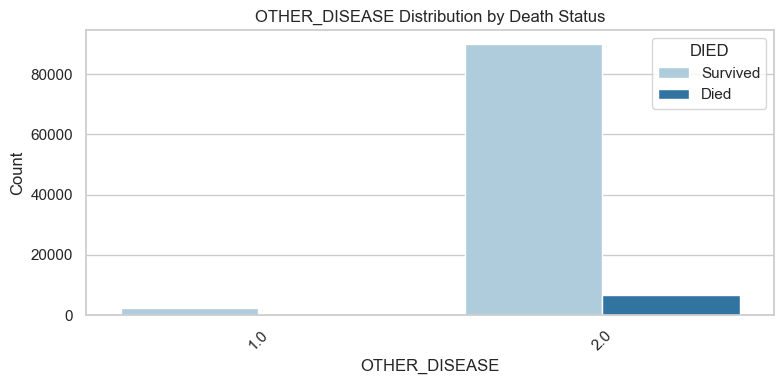

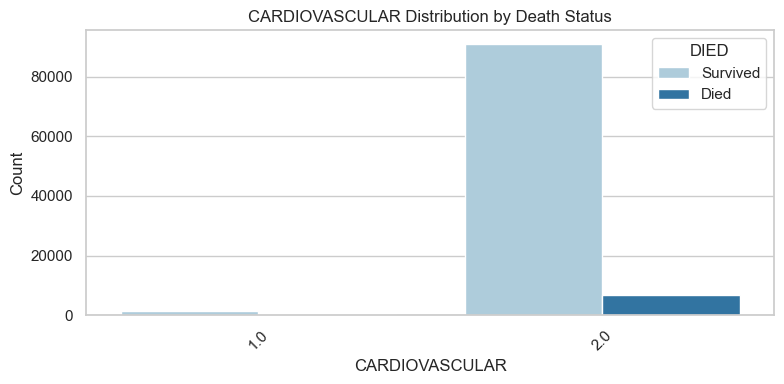

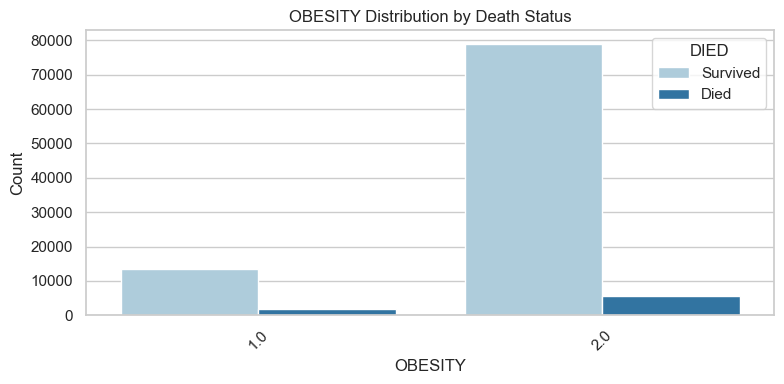

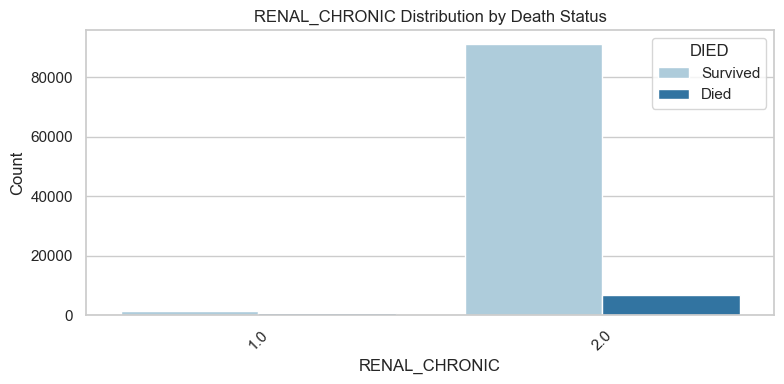

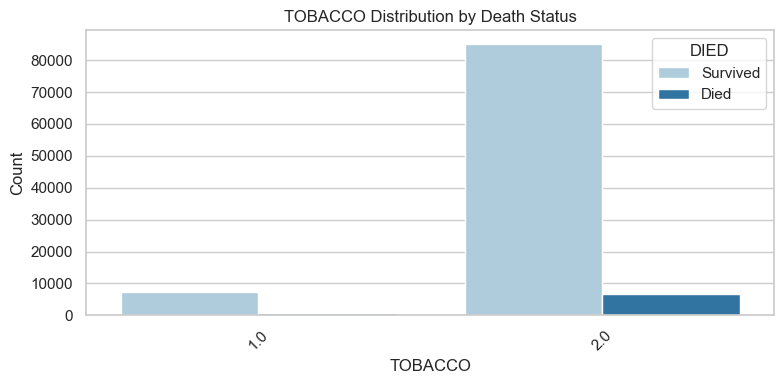

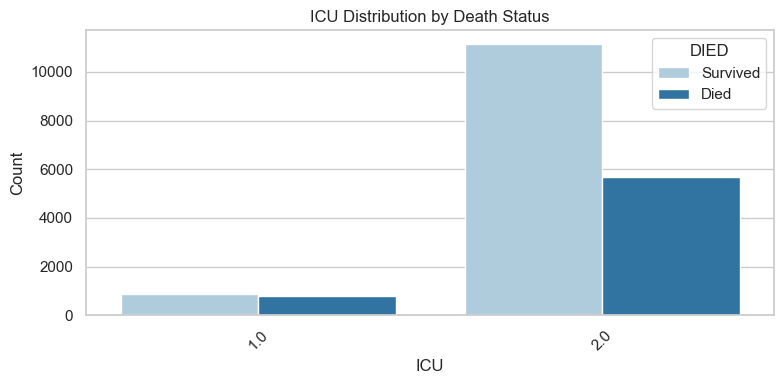

In [33]:
categorical_cols = [
    'SEX','INTUBED','PNEUMONIA','DIABETES','COPD','ASTHMA',
    'INMSUPR','HYPERTENSION','OTHER_DISEASE',
    'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','ICU'
]

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='DIED', palette='Paired')
    plt.title(f'{col} Distribution by Death Status')
    plt.xlabel(col); plt.ylabel('Count')
    plt.legend(title='DIED', labels=['Survived','Died'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 8·. 年龄分组 vs 死亡率

将 AGE 划分为区间，分析各组死亡情况

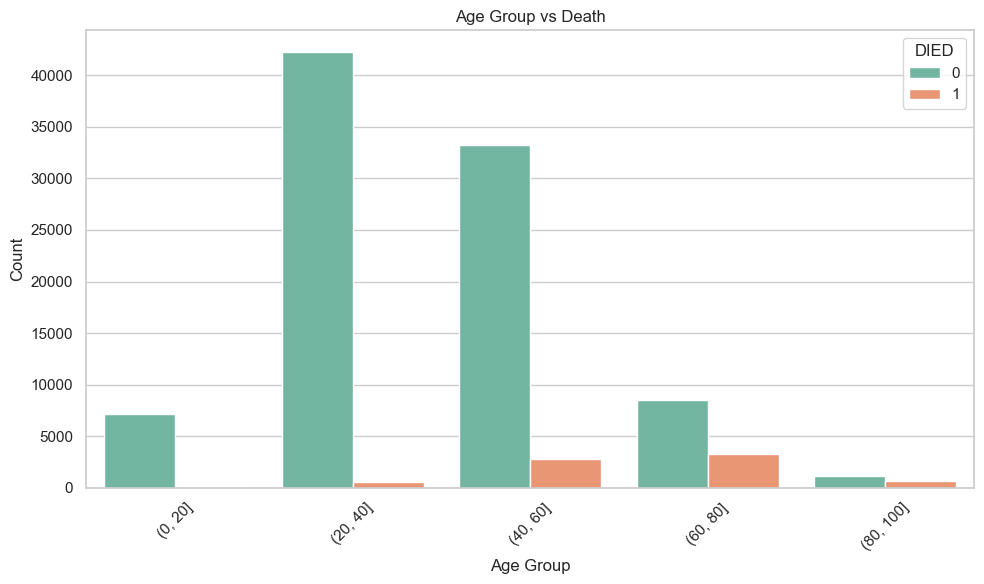

In [34]:
age_bins = [0,20,40,60,80,100]
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='AGE_GROUP', hue='DIED', palette='Set2')
plt.title('Age Group vs Death')
plt.xlabel('Age Group'); plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. 特征相关性 & Top-k 特征选择

Features ranked by |Spearman corr with DIED|:


PATIENT_TYPE      0.512000
PNEUMONIA         0.470572
INTUBED           0.411106
AGE               0.299127
DIABETES          0.216884
HYPERTENSION      0.207501
TEST_RESULT       0.199565
MEDICAL_UNIT      0.151065
RENAL_CHRONIC     0.123712
USMER             0.110983
COPD              0.092835
SEX               0.080704
ICU               0.079286
CARDIOVASCULAR    0.067317
OBESITY           0.063703
OTHER_DISEASE     0.056965
INMSUPR           0.052451
PREGNANT          0.021178
ASTHMA            0.018504
TOBACCO           0.007903
Name: DIED, dtype: float64

C:\Users\lixua\AppData\Local\Temp\ipykernel_61880\3163950642.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values[:top_n], y=target_corr.index[:top_n], palette='viridis')


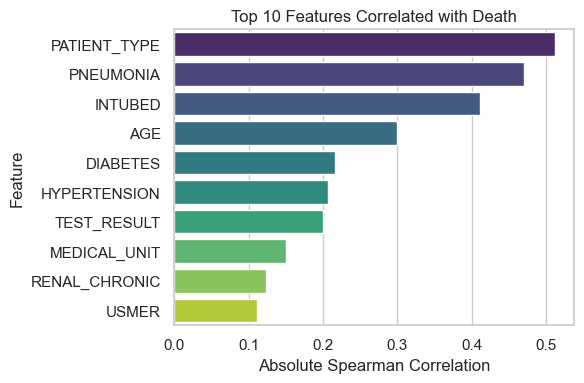

Top 5 features for classification: ['PATIENT_TYPE', 'PNEUMONIA', 'INTUBED', 'AGE', 'DIABETES']


In [37]:
# 1) 构造数值型 DataFrame，不包含非数值列
num_df = df.drop(columns=['AGE_GROUP', 'DATE_DIED'])

# 2) 只对本来就是 1/2 编码的分类特征做映射
for col in categorical_cols:
    num_df[col] = num_df[col].map({1: 1, 2: 0})

# 3) 保留 DIED 原始 0/1
num_df['DIED'] = df['DIED']

# 4) 计算 Spearman 相关矩阵
spearman_corr = num_df.corr(method='spearman')

# 5) 提取与目标 DIED 的绝对相关性并排序
target_corr = spearman_corr['DIED'].abs().drop('DIED').sort_values(ascending=False)

print("Features ranked by |Spearman corr with DIED|:")
display(target_corr)

# 6) 画 Top-10 特征条形图
top_n = 10
plt.figure(figsize=(6, 4))
sns.barplot(x=target_corr.values[:top_n], y=target_corr.index[:top_n], palette='viridis')
plt.title(f'Top {top_n} Features Correlated with Death')
plt.xlabel('Absolute Spearman Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 7) 记录 Top-5 特征列表，供后续建模使用
top_5_features = target_corr.index[:5].tolist()
print("Top 5 features for classification:", top_5_features)

## 10. 小结与下一步

- **缺失值**：已用 NaN 标记，后续可使用填补或删除策略  
- **异常值**：AGE 有少量离群值，可在建模前决定是否裁剪  
- **关键信号**：ICU、INTUBED、AGE、PNEUMONIA、HYPERTENSION 等与死亡最相关  
- **Top-5 特征**：`[...]` （见上表）  
- 下一步：使用 Top-5 特征构建 O1 分类模型（Decision Tree、LogisticRegression、RandomForest），并进行交叉验证与超参数调优。
